[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/milicagaljak/SpeechCommandRecognition/blob/main/01_main.ipynb)

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **Import necessary libs**

In [2]:
import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

In [3]:
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display

In [4]:
import tarfile

In [5]:
# Set seed for experiment reproducibility
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

In [6]:
!dir

drive  sample_data


## Dataset path

In [7]:
PATH = './drive/MyDrive/ml_dataset/speech_commands_v0.01.tar.gz'

# **Load Dataset**

## Extract data from drive

In [9]:
%%time

if PATH.endswith("tar.gz"):
    tar = tarfile.open(PATH, "r:gz")
    tar.extractall('./data/')
    tar.close()

CPU times: user 37.4 s, sys: 12.9 s, total: 50.3 s
Wall time: 1min 2s


In [10]:
#example of file for one random word
!ls data/cat/

004ae714_nohash_0.wav  5e3b7a84_nohash_0.wav  b06c19b0_nohash_2.wav
004ae714_nohash_1.wav  5e3b7a84_nohash_1.wav  b087aa0e_nohash_0.wav
00b01445_nohash_0.wav  5e3dde6b_nohash_0.wav  b087aa0e_nohash_1.wav
00f0204f_nohash_0.wav  5efb758c_nohash_0.wav  b087aa0e_nohash_2.wav
00f0204f_nohash_1.wav  5efb758c_nohash_1.wav  b0bad4a9_nohash_0.wav
00f0204f_nohash_2.wav  5f1b1051_nohash_0.wav  b1114e4f_nohash_0.wav
012c8314_nohash_0.wav  5f47fdf9_nohash_0.wav  b1114e4f_nohash_1.wav
0132a06d_nohash_0.wav  5f47fdf9_nohash_1.wav  b11a05d2_nohash_0.wav
0137b3f4_nohash_0.wav  5fadb538_nohash_0.wav  b12bef84_nohash_0.wav
01648c51_nohash_0.wav  5ff3f9a1_nohash_0.wav  b1426003_nohash_0.wav
016e2c6d_nohash_0.wav  5ff3f9a1_nohash_1.wav  b1426003_nohash_1.wav
01b4757a_nohash_0.wav  5ff3f9a1_nohash_2.wav  b1426003_nohash_2.wav
01bb6a2a_nohash_0.wav  6021f08b_nohash_0.wav  b1426003_nohash_3.wav
026290a7_nohash_0.wav  6021f08b_nohash_1.wav  b15fc37d_nohash_0.wav
030ec18b_nohash_0.wav  6021f08b_nohash_2.wav  b1

In [11]:
!ls data/_background_noise_/

doing_the_dishes.wav  exercise_bike.wav  README.md	  white_noise.wav
dude_miaowing.wav     pink_noise.wav	 running_tap.wav


In [12]:
#path of dataset files
data_dir = pathlib.Path('./data/')

In [14]:
commands = np.array(tf.io.gfile.listdir(str(data_dir)))

#TODO: include words starting with 't' and background_noise

commands = [x for x in commands if x not in {'LICENSE', 'README.md', 'validation_list.txt', 'testing_list.txt', '_background_noise_', 'two', 'three', 'tree'}]
#sample with two words: commands = [x for x in commands if x in {'cat', 'two'}]
print(commands)
print(len(commands))

['yes', 'four', 'eight', 'five', 'up', 'stop', 'wow', 'right', 'happy', 'sheila', 'bird', 'left', 'nine', 'house', 'marvin', 'seven', 'off', 'zero', 'bed', 'six', 'on', 'no', 'one', 'cat', 'down', 'dog', 'go']
27


## **Extract** the audio files into a list and **shuffle** it because of **distribution**.

Number of total examples:58259






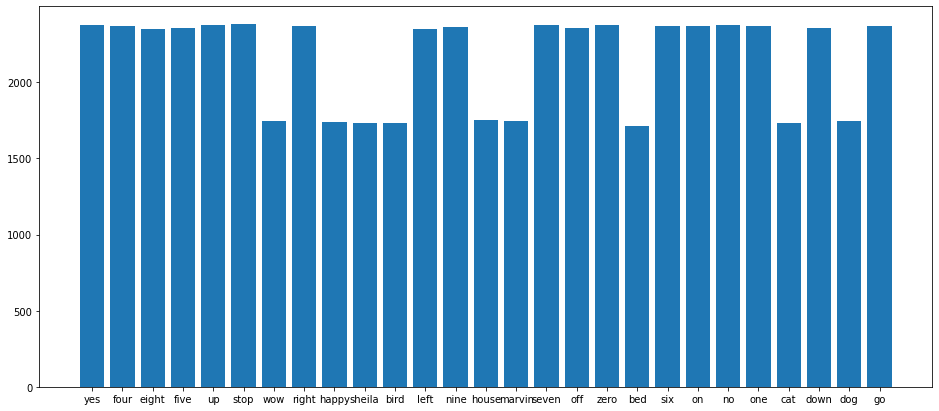





Example file tensor:   b'data/six/e53139ad_nohash_4.wav'


In [20]:
filenames = tf.io.gfile.glob(str(data_dir) + '/[^RLv_t]*/*')
filenames = tf.random.shuffle(filenames)

num_samples = len(filenames)
print('Number of total examples:{}\n\n\n\n'.format(num_samples))

distribution = []
for i in range(0, len(commands)):
  #print("Number of examples per label - {} : {}".format(commands[i], len(tf.io.gfile.listdir(str(data_dir/commands[i])))))
  distribution.append(len(tf.io.gfile.listdir(str(data_dir/commands[i]))))
#print(distribution)

plt.figure(figsize=(16,7))
plt.bar(commands, distribution,width=0.8)
plt.show()
print('\n\n\n\nExample file tensor:   {}'.format(filenames[0]))

## **Split** the files into **training, validation and test sets** using a 80:10:10 ratio.

In [22]:
#print(len(filenames))
train_files = filenames[:int(num_samples*0.8)]
val_files = filenames[int(num_samples*0.8): int(num_samples*0.8 + num_samples*0.1)]
test_files = filenames[int(-num_samples*0.1 - 1):]

print('Training set size: {}'.format(len(train_files)))
print('Validation set size: {}'.format(len(val_files)))
print('Test set size: {}'.format(len(test_files)))
#print(len(test_files) + len(val_files) + len(train_files))

Training set size: 46607
Validation set size: 5826
Test set size: 5826


## The audio file will initially be **read as a binary file**, which **we'll want to convert into a numerical tensor**.

## To **load** an audio file, we will use **tf.audio.decode_wav**, which returns **the WAV-encoded audio as a Tensor**.

In [25]:
def decode_audio(audio_binary):
  audio, _ = tf.audio.decode_wav(audio_binary)
  # print(tf.shape(tf.squeeze(audio, axis=-1)))
  return tf.squeeze(audio, axis=-1)


## The label (**target** value) for each WAV file is its **parent directory**.

In [27]:
def get_label(file_path):
  parts = tf.strings.split(file_path, os.path.sep)

  #print(len(parts))
  #example:./data/cat/*.wav
  # parts[-1]='*.wav', parts[-1]='cat'
  return parts[-2]

## A method that will take in the filename of the WAV file and **returns a tuple containing the audio and labels (target values)**.

In [28]:
def get_waveform_and_label(file_path):
  #target value
  label = get_label(file_path)
  #binary read
  audio_binary = tf.io.read_file(file_path)
  #decoding binary file
  waveform = decode_audio(audio_binary)
  # X instance , y target
  return waveform, label

We will apply process_path to build our training set to extract the audio-label pairs and check the results. We'll build the validation and test sets using a similar procedure later on.

In [30]:
#Represents a potentially large set of elements.
dataset = tf.data.Dataset.from_tensor_slices([1, 2, 3])
for element in dataset:
  print(element)

tf.Tensor(1, shape=(), dtype=int32)
tf.Tensor(2, shape=(), dtype=int32)
tf.Tensor(3, shape=(), dtype=int32)


In [37]:
# tf.data.AUTOTUNE - delegate the decision about what level of parallelism to use to the tf.data runtime.
AUTOTUNE = tf.data.AUTOTUNE

print(type(train_files))
files_ds = tf.data.Dataset.from_tensor_slices(train_files)
print(type(files_ds))

waveform_ds = files_ds.map(get_waveform_and_label, num_parallel_calls=AUTOTUNE)

#dataset od tuples
print(type(waveform_ds))
#unit
print(waveform_ds.element_spec)
print(type(waveform_ds.element_spec))

<class 'tensorflow.python.framework.ops.EagerTensor'>
<class 'tensorflow.python.data.ops.dataset_ops.TensorSliceDataset'>
<class 'tensorflow.python.data.ops.dataset_ops.ParallelMapDataset'>
(TensorSpec(shape=(None,), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.string, name=None))
<class 'tuple'>


### A few audio waveforms with their corresponding labels.

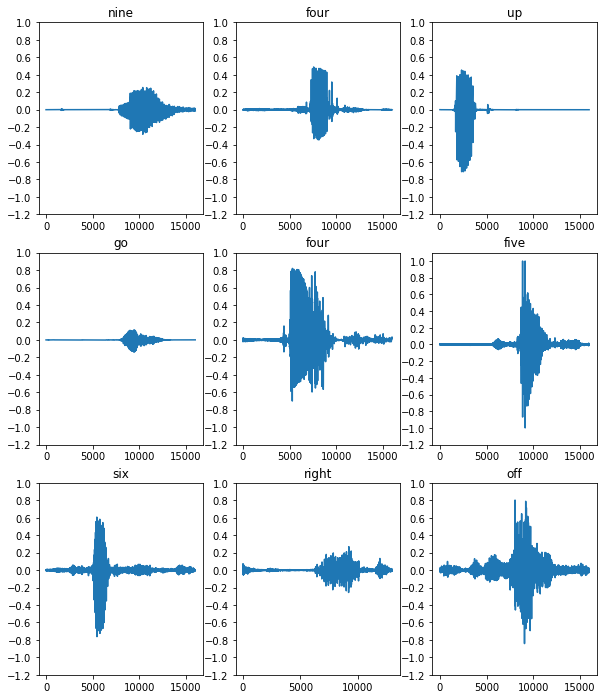

In [ ]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 12))

for i, (audio, label) in enumerate(waveform_ds.take(n)):
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  ax.plot(audio.numpy())
  ax.set_yticks(np.arange(-1.2, 1.2, 0.2))
  label = label.numpy().decode('utf-8')
  ax.set_title(label)

plt.show()

# Spectrogram

## About spectogram:

### We'll convert the waveform into a spectrogram, which ***shows frequency changes over time*** and can be represented as a 2D image. This can be done ***by applying the short-time Fourier transform*** (STFT) to ***convert the audio into the time-frequency domain.***

A Fourier transform (tf.signal.fft) converts a signal to its component frequencies, but loses all time information. The STFT (tf.signal.stft) splits the signal into windows of time and runs a Fourier transform on each window, preserving some time information, and returning a 2D tensor that we can run standard convolutions on.

STFT produces an array of complex numbers representing magnitude and phase. However, *we'll only need the magnitude for this model, which can be derived by applying tf.abs on the output of tf.signal.stft*.

We also want *the waveforms to have the same length*, so that when we convert it to a spectrogram image, the results will have similar dimensions. This can be done by simply *zero padding the audio clips that are shorter than one second*.

In [39]:
def get_spectrogram(waveform):
  # Padding for files with less than 16000 samples
  zero_padding = tf.zeros([16000] - tf.shape(waveform), dtype=tf.float32)

  # Concatenate audio with padding so that all audio clips will be of the 
  # same length
  waveform = tf.cast(waveform, tf.float32)
  equal_length = tf.concat([waveform, zero_padding], 0)

  # Converts the audio into the time-frequency domain
  spectrogram = tf.signal.stft(
      equal_length, frame_length=255, frame_step=128)

  spectrogram = tf.abs(spectrogram)

  return spectrogram

### Compare the waveform, the spectrogram and the actual audio of one example from the dataset.

In [61]:
# waveform_ds - train set
for waveform, label in waveform_ds.take(1):
  label = label.numpy().decode('utf-8')
  spectrogram = get_spectrogram(waveform)

print('Label:', label)
print('Waveform shape:', waveform.shape)
print('Spectrogram shape:', spectrogram.shape)

print('Audio playback')
display.display(display.Audio(waveform, rate=16000))

Label: six
Waveform shape: (16000,)
Spectrogram shape: (124, 129)
Audio playback


### Example of one waveform

In [50]:
print(waveform)

tf.Tensor(
[0.0000000e+00 6.1035156e-05 9.1552734e-05 ... 6.1035156e-05 6.1035156e-05
 9.1552734e-05], shape=(16000,), dtype=float32)


### Example of one spectogram

In [49]:
print(spectrogram)

tf.Tensor(
[[1.88893755e-04 1.01969088e-03 1.45527988e-03 ... 1.07370186e-04
  4.64038094e-05 1.59893607e-05]
 [2.72666162e-04 8.33513739e-04 1.55312777e-03 ... 5.65104929e-05
  3.02182671e-05 4.25361286e-05]
 [2.42138849e-05 7.75672670e-04 8.66337970e-04 ... 5.22773407e-05
  4.02095793e-05 7.98794281e-05]
 ...
 [8.56781960e-04 2.12294934e-03 4.67799837e-03 ... 2.99346011e-05
  4.90843886e-05 7.97002867e-05]
 [7.31507142e-04 1.29748858e-03 1.57983531e-03 ... 7.50476756e-05
  3.41771447e-05 6.80547091e-05]
 [7.70596380e-05 1.97878457e-03 3.03393370e-03 ... 8.43935995e-05
  3.75499549e-05 3.34021570e-05]], shape=(124, 129), dtype=float32)


### Plot Spectogram

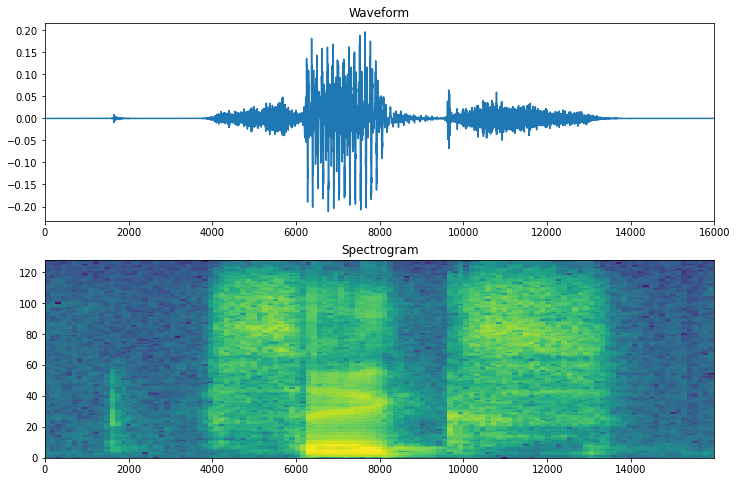

In [63]:
def plot_spectrogram(spectrogram, ax):
  # Convert to frequencies to log scale and transpose so that the time is
  # represented in the x-axis (columns).
  #print(spectrogram.shape)
  #print(spectrogram.T.shape)
  log_spec = np.log(spectrogram.T)
  #print(log_spec.shape)

  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)


fig, axes = plt.subplots(2, figsize=(12, 8))
#print(waveform.shape)

timescale = np.arange(waveform.shape[0])

axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 16000])
#print(spectrogram.numpy().shape)
plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.show()






















### Transform the waveform dataset to have spectrogram images and their corresponding labels as integer IDs.

In [64]:
def get_spectrogram_and_label_id(audio, label):
  spectrogram = get_spectrogram(audio)
  spectrogram = tf.expand_dims(spectrogram, -1)
  label_id = tf.argmax(label == commands)
  return spectrogram, label_id

### Spectograms train set

In [65]:
spectrogram_ds = waveform_ds.map(
    get_spectrogram_and_label_id, num_parallel_calls=AUTOTUNE)

### Example of some spectograms from train set

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log
  


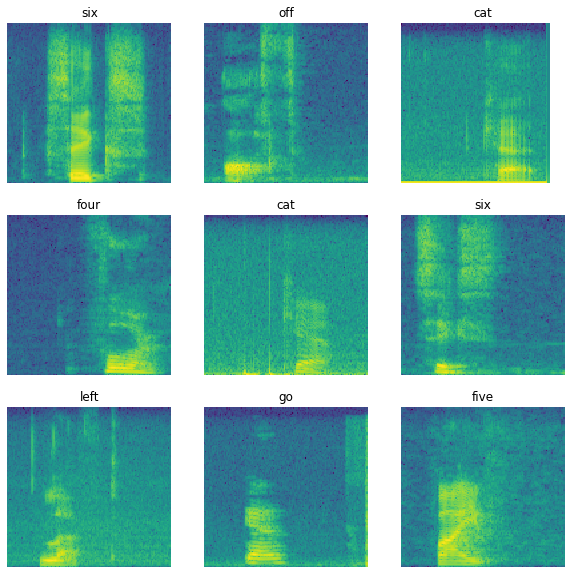

In [66]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 10))
for i, (spectrogram, label_id) in enumerate(spectrogram_ds.take(n)):
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  plot_spectrogram(np.squeeze(spectrogram.numpy()), ax)
  ax.set_title(commands[label_id.numpy()])
  ax.axis('off')

plt.show()

# **Build and train the model**

## ***Preprocessing validation and test set***
### We did it for train set.

In [68]:
def preprocess_dataset(files):
  files_ds = tf.data.Dataset.from_tensor_slices(files)
  output_ds = files_ds.map(get_waveform_and_label, num_parallel_calls=AUTOTUNE)
  output_ds = output_ds.map(
      get_spectrogram_and_label_id,  num_parallel_calls=AUTOTUNE)
  return output_ds

In [69]:
train_ds = spectrogram_ds
val_ds = preprocess_dataset(val_files)
test_ds = preprocess_dataset(test_files)

### Batch the training and validation sets for model training.

In [70]:
batch_size = 64
train_ds = train_ds.batch(batch_size)
val_ds = val_ds.batch(batch_size)

### Add dataset cache() and prefetch() operations to reduce read latency while training the model.

In [71]:
train_ds = train_ds.cache().prefetch(AUTOTUNE)
val_ds = val_ds.cache().prefetch(AUTOTUNE)

# -------------***Model***-----------------

For the model, we'll use a simple convolutional neural network (CNN),
since we have transformed the audio files into spectrogram images.

The model also has the following additional preprocessing layers:

A **Resizing layer** to downsample the input to enable the model to train faster.

A **Normalization layer** to normalize each pixel in the image based on its mean and standard deviation.

For the Normalization layer, its *adapt method* would first need to be called *on the training data in order to compute aggregate statistics* (i.e. mean and standard deviation)

In [73]:
%%time

for spectrogram, _ in spectrogram_ds.take(1):
  input_shape = spectrogram.shape
print('Input shape:', input_shape)
num_labels = len(commands)

norm_layer = preprocessing.Normalization()
norm_layer.adapt(spectrogram_ds.map(lambda x, _: x))

model = models.Sequential([
    layers.Input(shape=input_shape),
    preprocessing.Resizing(32, 32), 
    norm_layer,
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels),
])

model.summary()

Input shape: (124, 129, 1)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resizing (Resizing)          (None, 32, 32, 1)         0         
_________________________________________________________________
normalization_2 (Normalizati (None, 32, 32, 1)         3         
_________________________________________________________________
conv2d (Conv2D)              (None, 30, 30, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 64)        18496     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0         
_________________________________________________________________
flatten (Flatten)            

## **Optimizer, Loss and Metrics for model**

In [74]:
model.compile(
  optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    #loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

## **Fitting model**

In [75]:
#EPOCHS = 4
EPOCHS = 10
history = model.fit(
    train_ds, 
    validation_data=val_ds,  
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2)
)

Epoch 1/10
729/729 [==============================] - 303s 413ms/step - loss: 2.0954 - accuracy: 0.3944 - val_loss: 1.0939 - val_accuracy: 0.7113
Epoch 2/10
729/729 [==============================] - 162s 223ms/step - loss: 1.1661 - accuracy: 0.6526 - val_loss: 0.7330 - val_accuracy: 0.7947
Epoch 3/10
729/729 [==============================] - 162s 223ms/step - loss: 0.9188 - accuracy: 0.7217 - val_loss: 0.6358 - val_accuracy: 0.8251
Epoch 4/10
729/729 [==============================] - 162s 223ms/step - loss: 0.7917 - accuracy: 0.7604 - val_loss: 0.5577 - val_accuracy: 0.8419
Epoch 5/10
729/729 [==============================] - 162s 222ms/step - loss: 0.6915 - accuracy: 0.7894 - val_loss: 0.5150 - val_accuracy: 0.8570
Epoch 6/10
729/729 [==============================] - 162s 222ms/step - loss: 0.6437 - accuracy: 0.8037 - val_loss: 0.4932 - val_accuracy: 0.8579
Epoch 7/10
729/729 [==============================] - 161s 221ms/step - loss: 0.5890 - accuracy: 0.8176 - val_loss: 0.4806 -

history.params: {'verbose': 1, 'epochs': 10, 'steps': 729}
history.history.keys() : dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])
train loss : 0.49
train accuracy : 0.85
validation loss : 0.45
validation accuracy : 0.87


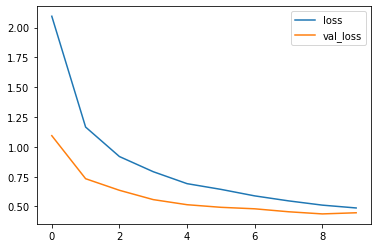

In [97]:


metrics = history.history
print('history.params: {}'.format(history.params))
print('history.history.keys() : {}'.format(history.history.keys()))

print('train loss : {0:.2f}'.format(history.history['loss'][-1]))
print('train accuracy : {0:.2f}'.format(history.history['accuracy'][-1]))
print('validation loss : {0:.2f}'.format(history.history['val_loss'][-1]))
print('validation accuracy : {0:.2f}'.format(history.history['val_accuracy'][-1]))

plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.show()

# ***Evaluate model***

In [79]:
test_audio = []
test_labels = []
#print(type(test_ds))

for audio, label in test_ds:
  test_audio.append(audio.numpy())
  test_labels.append(label.numpy())

test_audio = np.array(test_audio)
test_labels = np.array(test_labels)
# test_audio[91]
# test_labels[91]

In [91]:
y_pred = np.argmax(model.predict(test_audio), axis=1)
print('y_pred:\n {}'.format(y_pred))
print('len(y_pred): {}'.format(len(y_pred)))
y_true = test_labels
# err_index = y_pred != y_true
# #print(err_index)
# print(len(err_index))
# indexes = list(range(0,len(err_index)))

# #print(indexes)
# map = zip(indexes, err_index )
# for key, value in map:
#   #print (key, value)
#   if value == True:
#      print(key, value)
test_acc = sum(y_pred == y_true) / len(y_true)
print(f'Test set accuracy: {test_acc:.2%}')


y_pred:
 [ 2 26 21 ...  0 25 18]
len(y_pred): 5826
Test set accuracy: 87.49%


In [100]:
test_loss, test_acc = model.evaluate(test_audio, test_labels)
print ("Test loss: {}, test accuracy: {}".format(test_loss, test_acc))

183/183 [==============================] - 6s 31ms/step - loss: 0.4443 - accuracy: 0.8749
Test loss: 0.4443296194076538, test accuracy: 0.8748712539672852


# ***Display a confusion matrix***

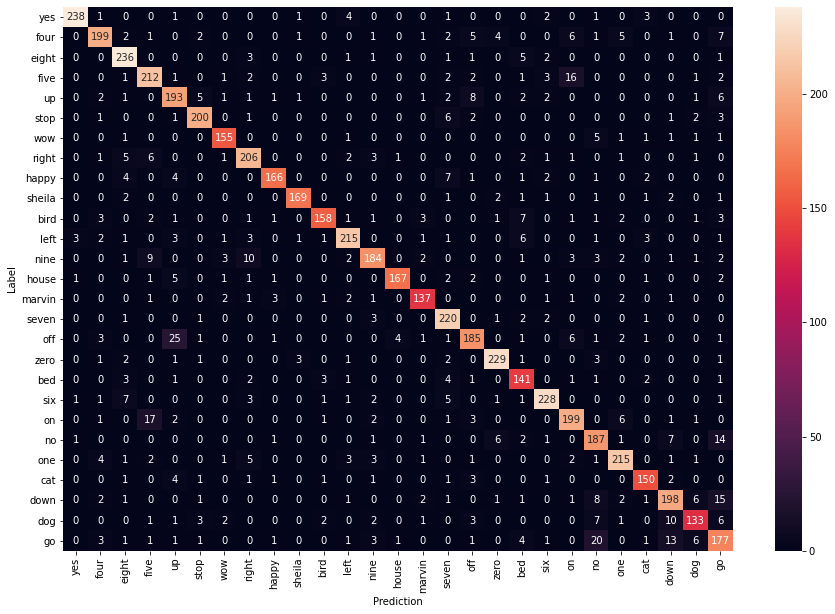

In [81]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred) 
plt.figure(figsize=(15, 10))
sns.heatmap(confusion_mtx, xticklabels=commands, yticklabels=commands, 
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

# **Run inference on an audio file**
### We choose random *.wav file and test how our model predicts target value.

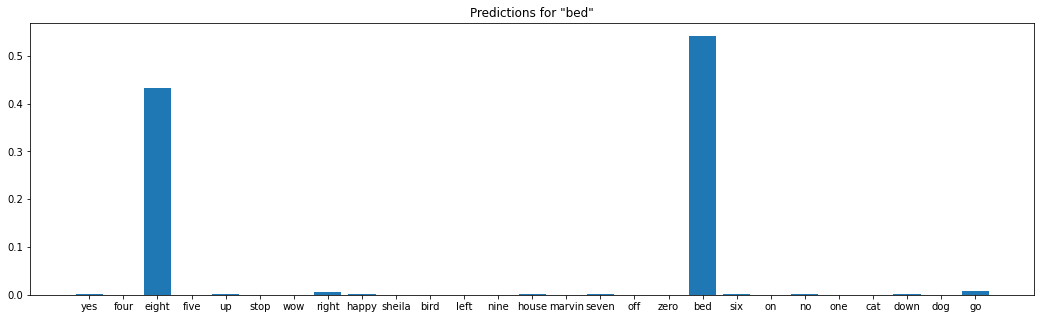

In [90]:
sample_file = './data/bed/014f9f65_nohash_0.wav'

sample_ds = preprocess_dataset([str(sample_file)])

for spectrogram, label in sample_ds.batch(1):
  prediction = model(spectrogram)
  plt.figure(figsize=(18,5))
  plt.bar(commands, tf.nn.softmax(prediction[0]))
  plt.title(f'Predictions for "{commands[label[0]]}"')
  plt.show()

# **Save model**

In [101]:
weights = model.weights

In [102]:
len(weights)

11

In [104]:
for i in range(0, len(weights)): 
    print(weights[i].shape)

(1,)
(1,)
()
(3, 3, 1, 32)
(32,)
(3, 3, 32, 64)
(64,)
(12544, 128)
(128,)
(128, 27)
(27,)


In [118]:


model.save_weights('./weights/sample_cnn_weights.hdf5')

In [108]:
!ls


data  drive  sample_cnn_weights.hdf5  sample_data


In [109]:
model.get_config()

{'layers': [{'class_name': 'InputLayer',
   'config': {'batch_input_shape': (None, 124, 129, 1),
    'dtype': 'float32',
    'name': 'input_1',
    'ragged': False,
    'sparse': False}},
  {'class_name': 'Resizing',
   'config': {'crop_to_aspect_ratio': False,
    'dtype': 'float32',
    'height': 32,
    'interpolation': 'bilinear',
    'name': 'resizing',
    'trainable': True,
    'width': 32}},
  {'class_name': 'Normalization',
   'config': {'axis': (-1,),
    'batch_input_shape': (None, None, None),
    'dtype': 'float32',
    'mean': None,
    'name': 'normalization_2',
    'trainable': True,
    'variance': None}},
  {'class_name': 'Conv2D',
   'config': {'activation': 'relu',
    'activity_regularizer': None,
    'bias_constraint': None,
    'bias_initializer': {'class_name': 'Zeros', 'config': {}},
    'bias_regularizer': None,
    'data_format': 'channels_last',
    'dilation_rate': (1, 1),
    'dtype': 'float32',
    'filters': 32,
    'groups': 1,
    'kernel_constraint': 

In [117]:

model.save('./models/sample_cnn.hdf5')

In [114]:
# If we want to use this model again we can use method load_model from tensorflow.keras.models
#from tensorflow.keras.models import load_model
#model_revived = load_model('sample_cnn.hdf5')


## **Plot model**

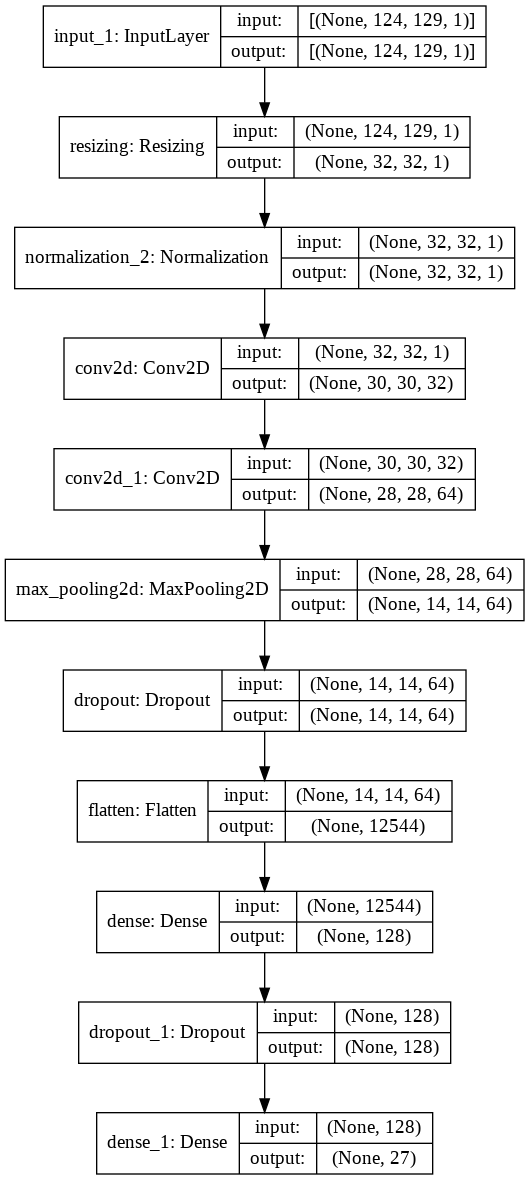

In [116]:
from tensorflow.keras import utils
utils.plot_model(model, to_file='./image/sample_cnn_model_img.png', show_shapes=True)